In [29]:
import numpy as np
import os

from glob import glob

from keras.src.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.text import text_to_word_sequence
## 라벨인코더-> 카테고리형 문자를 숫자로 자동 변환해주는 역할
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 딥러닝 모델을 만들자!!!!!!!
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from tensorflow.keras.preprocessing import *


In [30]:
import os
print("현재 작업 폴더:", os.getcwd())

현재 작업 폴더: C:\Users\Administrator\Documents\deep\deep01


In [31]:
from pathlib import Path

# 현재 작업 폴더가 ...\img-animal 이면
base = Path("img-animal")   # 현재 폴더

cat_files = sorted((base / "cat").glob("*.jpg"))
dog_files = sorted((base / "dog").glob("*.jpg"))

print("cat jpg 개수:", len(cat_files))
print("dog jpg 개수:", len(dog_files))

data_files = cat_files + dog_files
print("전체 jpg 개수:", len(data_files))
print("예시:", data_files[0])


cat jpg 개수: 2000
dog jpg 개수: 2000
전체 jpg 개수: 4000
예시: img-animal\cat\cat.0.jpg


In [32]:
data_files[0]

WindowsPath('img-animal/cat/cat.0.jpg')

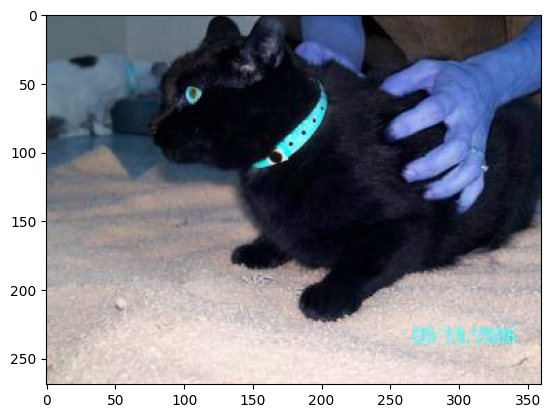

In [33]:
img0 = cv2.imread(data_files[100])
plt.imshow(img0)

In [56]:
def make_file(data_height, data_width, channel_n, data_list_n):
    ## 라벨링한 결과 넣어줄 1차원 리스트 필요
    label = []

    ## 4차원으로 만들어줄 4차원 리스트 필요
    images = np.zeros((data_list_n, data_height, data_width, channel_n))
    
     ## 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징하자!
    for i, image in enumerate(data_files):
        folder = str(image).split('\\')[1]
        # print(folder)
        result = 0
        if folder == 'dog':
            result = 1
        label.append(result)
        
        ## 읽어서, 스케일링, 리사이징해서
        image2 = cv2.imread(image)
        image3 = cv2.resize(image2, (data_height, data_width)) / 255
        
        ## 4차원 리스트에 하나씩 끼자
        images[i, :, :, : ] = image3
    label2 = np.array(label)
    return label2, images

In [57]:
data_height=150
data_width=150
channel_n=3

In [58]:
labels, images = make_file(data_height, data_width, channel_n, 4000)

In [59]:
x = images
y = labels

In [61]:
labels[0:10], labels[-11:-1]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size= 0.2,
                                                    random_state=55
                                                   )
print(X_train.shape, X_test.shape)

(3200, 150, 150, 3) (800, 150, 150, 3)


In [63]:
data_height

150

In [64]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # 이걸로 통일

cnn_base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(data_height, data_width, channel_n)
)
cnn_base.trainable = False
# 역전파를 해도 가중치가 업데이트되지 않음

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

model = Sequential()
model.add(tf.keras.Input(shape=(data_height, data_width, channel_n)))

model.add(cnn_base)

# 이 줄이 핵심: 그냥 GlobalAveragePooling2D() 호출이 아니라 add로 넣어야 함
model.add(GlobalAveragePooling2D())

model.add(Dense(1, activation="sigmoid"))


In [66]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [67]:
es = EarlyStopping(patience=3, restore_best_weights=True)
cp = ModelCheckpoint('best_cnn_final.h5')

In [68]:
cnn_history = model.fit(
                X_train,
                y_train,
                batch_size=128,
                epochs=10,
                validation_data= (X_test, y_test), 
                callbacks=[es, cp],
                verbose=2
)

Epoch 1/10


25/25 - 83s - 3s/step - accuracy: 0.5066 - loss: 0.6951 - val_accuracy: 0.5475 - val_loss: 0.6879
Epoch 2/10


25/25 - 83s - 3s/step - accuracy: 0.5450 - loss: 0.6868 - val_accuracy: 0.5775 - val_loss: 0.6819
Epoch 3/10


25/25 - 88s - 4s/step - accuracy: 0.5572 - loss: 0.6827 - val_accuracy: 0.5938 - val_loss: 0.6770
Epoch 4/10


25/25 - 85s - 3s/step - accuracy: 0.5878 - loss: 0.6787 - val_accuracy: 0.6037 - val_loss: 0.6729
Epoch 5/10


25/25 - 86s - 3s/step - accuracy: 0.5694 - loss: 0.6767 - val_accuracy: 0.6263 - val_loss: 0.6699
Epoch 6/10


25/25 - 78s - 3s/step - accuracy: 0.5794 - loss: 0.6748 - val_accuracy: 0.6150 - val_loss: 0.6676
Epoch 7/10


25/25 - 75s - 3s/step - accuracy: 0.5925 - loss: 0.6699 - val_accuracy: 0.6212 - val_loss: 0.6651
Epoch 8/10


25/25 - 91s - 4s/step - accuracy: 0.6031 - loss: 0.6680 - val_accuracy: 0.6162 - val_loss: 0.6634
Epoch 9/10


25/25 - 80s - 3s/step - accuracy: 0.6044 - loss: 0.6671 - val_accuracy: 0.6350 - val_loss: 0.6614
Epoch 10/10


25/25 - 119s - 5s/step - accuracy: 0.6053 - loss: 0.6651 - val_accuracy: 0.6288 - val_loss: 0.6606


In [69]:
test_result = model.evaluate(X_test,y_test) 
test_result

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 981ms/step - accuracy: 0.6288 - loss: 0.6606


[0.6605949997901917, 0.6287500262260437]

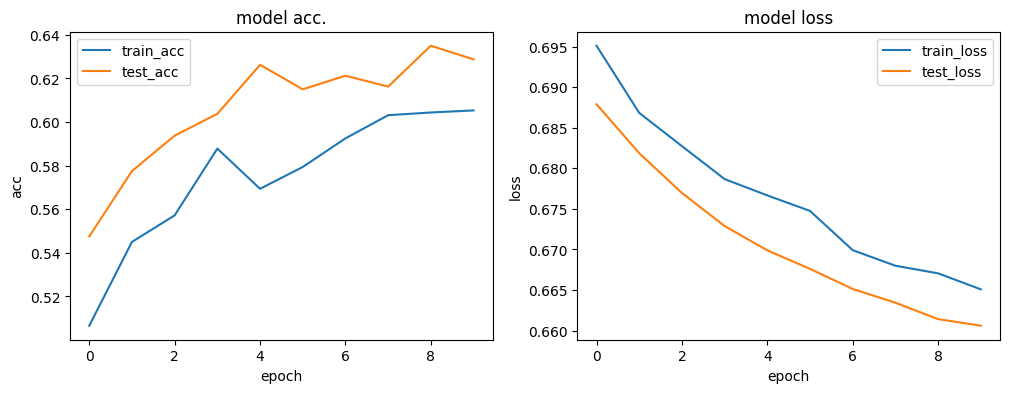

In [70]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])

In [71]:
load_model_final = load_model('./best_cnn_final.h5')
load_model_final

<Sequential name=sequential_2, built=True>

In [72]:
final_result2 = load_model_final.predict(X_test)
final_result2[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 925ms/step


array([[0.6959644 ],
       [0.51527137],
       [0.40791434],
       [0.452627  ],
       [0.43564472],
       [0.46279383],
       [0.7553526 ],
       [0.44234866],
       [0.57178426],
       [0.43452886]], dtype=float32)

In [76]:
y_test[:10]

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [77]:
final_result3 = []
for x in final_result2:
    if x > 0.5 :
        final_result3.append(1)
    else:
        final_result3.append(0)
final_result3[:10]

[1, 1, 0, 0, 0, 0, 1, 0, 1, 0]

In [78]:
np.mean(final_result3 == y_test)

np.float64(0.62875)